In [1]:
!gdown 12zzlX4sUENjQIApr7xpuF7Mcf4GNpB8c
!unzip -q brain-tumor.zip

Downloading...
From (original): https://drive.google.com/uc?id=12zzlX4sUENjQIApr7xpuF7Mcf4GNpB8c
From (redirected): https://drive.google.com/uc?id=12zzlX4sUENjQIApr7xpuF7Mcf4GNpB8c&confirm=t&uuid=fb7d0d45-bb83-49b6-8fe3-a354688b9e88
To: /kaggle/working/brain-tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:02<00:00, 62.3MB/s]


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from tqdm.notebook import tqdm

def get_transform(path):
    dataset = ImageFolder(path, transform=v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True)
    ]))

    mean = torch.zeros(3)
    for image, _ in tqdm(dataset, "Computing mean"):
        mean += image.mean(dim=(1, 2))
    mean /= len(dataset)

    mean_img = mean.view(3, 1, 1).expand(-1, 224, 224)

    std = torch.zeros(3)
    for image, _ in tqdm(dataset, "Computing std"):
        d = image - mean_img
        std += (d * d).mean(dim=(1, 2))
    std = torch.sqrt((std / len(dataset)))

    print(mean, std)
    jitter = 0.1

    transform_augment = v2.Compose([
        v2.RandomRotation(degrees=7.2),
        v2.Resize(256, antialias=True),
        v2.RandomCrop(size=(224, 224)),
        v2.RandomHorizontalFlip(),
        # v2.RandomVerticalFlip(),

        v2.RandAugment(),
        v2.ColorJitter(jitter, jitter, jitter),

        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean, std)
    ])

    transform = v2.Compose([
        v2.Resize(256, antialias=True),
        v2.CenterCrop(224),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean, std)
    ])

    return transform_augment, transform

transform_augment, transform = get_transform("Training")
dataset = ImageFolder("Training", transform=transform_augment)

Computing mean:   0%|          | 0/5712 [00:00<?, ?it/s]

Computing std:   0%|          | 0/5712 [00:00<?, ?it/s]

tensor([0.1855, 0.1855, 0.1855]) tensor([0.2003, 0.2003, 0.2004])


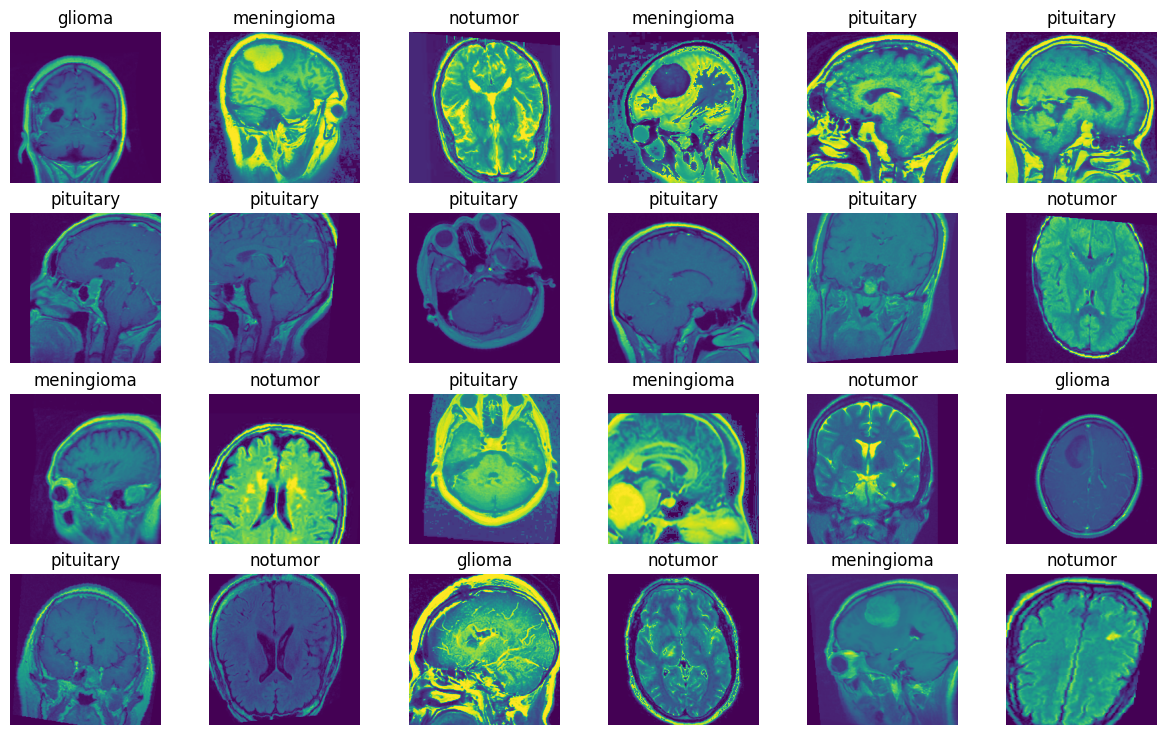

In [3]:
import matplotlib.pyplot as plt

def visualize(dataset, seed):
    n_rows = 4
    n_cols = 6
    torch.manual_seed(seed)
    rng = torch.Generator().manual_seed(seed)
    loader = DataLoader(dataset, n_rows * n_cols, True, generator=rng)

    imgs, labels = next(iter(loader))

    imgs = imgs.view([n_rows, n_cols] + list(imgs.shape[1:]))
    labels = labels.view([n_rows, n_cols] + list(labels.shape[1:]))

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 9))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i][j].imshow(imgs[i][j].mean(dim=0))
            ax[i][j].set_title(dataset.classes[labels[i][j].item()])
            ax[i][j].axis("off")

    return fig

visualize(dataset, 42).show()

In [4]:
rng = torch.Generator().manual_seed(42)

train_dataset, valid_dataset = random_split(dataset, [0.8, 0.2], generator=rng)
valid_dataset.transform = transform

test_dataset = ImageFolder("/kaggle/working/Testing", transform=transform)

train_loader = DataLoader(train_dataset, 32, True, generator=rng)
valid_loader = DataLoader(valid_dataset, 32, False, generator=rng)
test_loader = DataLoader(test_dataset, 32, False, generator=rng)

In [5]:
dataset.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
test_dataset.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
from tqdm.notebook import tqdm

def evaluate(name, model, loader, loss_fn, metric_fn, device):
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_metric = 0
        pbar = tqdm(loader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = loss_fn(preds, labels)
            metric = metric_fn(preds, labels)

            valid_loss = (valid_loss * i + loss.item()) / (i + 1)
            valid_metric = (valid_metric * i + metric.item()) / (i + 1)
            pbar.set_description(f"[{name}] Loss: {valid_loss:.4f} - Metric: {valid_metric:.4f}")

        return valid_loss, valid_metric


class TrainResult:
    def __init__(self):
        self.train_loss = []
        self.train_metric = []
        self.valid_loss = []
        self.valid_metric = []
        self.best_metric = 0.0


def train(model, train_loader, valid_loader, optimizer, scheduler, loss_fn, metric_fn, epochs, device):
    hist = TrainResult()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}:")
        model.train()
        train_loss = 0
        train_metric = 0
        pbar = tqdm(train_loader)
        for i, (images, labels) in enumerate(pbar):
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = loss_fn(preds, labels)
            metric = metric_fn(preds, labels)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss = (train_loss * i + loss.item()) / (i + 1)
            train_metric = (train_metric * i + metric.item()) / (i + 1)
            pbar.set_description(f"[Training] Loss: {train_loss:.4f} - Metric: {train_metric:.4f}")
        if scheduler:
            scheduler.step()

        hist.train_loss.append(train_loss)
        hist.train_metric.append(train_metric)

        valid_loss, valid_metric = evaluate("Validation", model, valid_loader, loss_fn, metric_fn, device)
        hist.valid_loss.append(valid_loss)
        hist.valid_metric.append(valid_metric)
        if valid_metric > hist.best_metric:
            hist.best_metric = valid_metric
            hist.best_model = model.state_dict()

    hist.last_model = model.state_dict()
    return hist

In [8]:
import timm
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = timm.create_model('resnet34.a1_in1k', pretrained=True, num_classes=4)
model = model.to(device)

def accuracy(preds, labels):
    return (preds.argmax(axis=1) == labels).float().mean()

num_epochs = 10
adam = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam, T_max=num_epochs)
criterion = nn.functional.cross_entropy

hist = train(model, train_loader, valid_loader, adam, scheduler, criterion, accuracy, num_epochs, device)

result_resnet = {
    "train_loss": hist.train_loss,
    "train_metric": hist.train_metric,
    "valid_loss": hist.valid_loss,
    "valid_metric": hist.valid_metric,
}

torch.save(hist.best_model, "brain-tumor-resnet.pt")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Test acc (last) = 0.9664634146341463, Test acc (best) = 0.9664634146341463


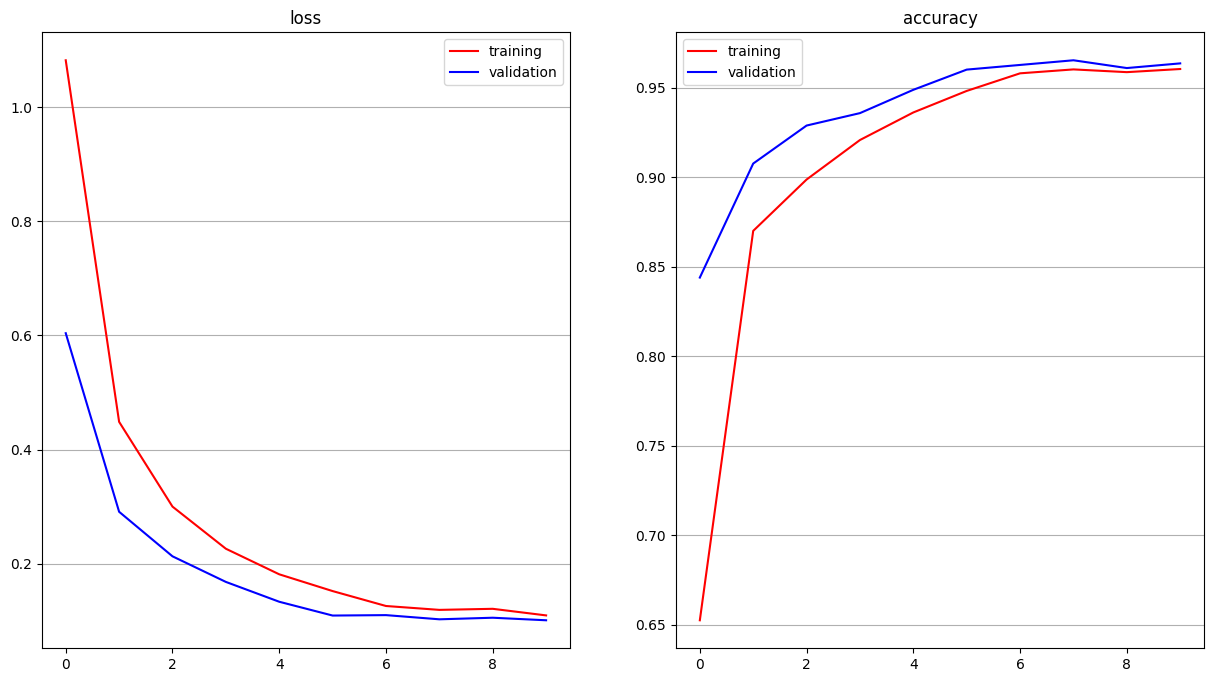

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(range(num_epochs), hist.train_loss, label='training', color='r')
ax[0].plot(range(num_epochs), hist.valid_loss, label='validation', color='b')
ax[0].set_title('loss')
ax[0].legend()
ax[0].grid(axis='y')

ax[1].plot(range(num_epochs), hist.train_metric, label='training', color='r')
ax[1].plot(range(num_epochs), hist.valid_metric, label='validation', color='b')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].grid(axis='y')

model.load_state_dict(hist.last_model)
_, last_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
model.load_state_dict(hist.best_model)
_, best_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
print(f"Test acc (last) = {last_acc}, Test acc (best) = {best_acc}")

In [10]:
def evaluate_model(model, test_loader, class_names, device):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix

    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Classification Report ---
    print("Classification Report:\n")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    ))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # --- Accuracy ---
    accuracy = (y_true == y_pred).mean()
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy, cm


In [11]:
class_names = test_dataset.classes
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9862    0.9500    0.9677       300
  meningioma     0.9204    0.9444    0.9323       306
     notumor     0.9779    0.9852    0.9815       405
   pituitary     0.9800    0.9800    0.9800       300

    accuracy                         0.9664      1311
   macro avg     0.9661    0.9649    0.9654      1311
weighted avg     0.9669    0.9664    0.9665      1311



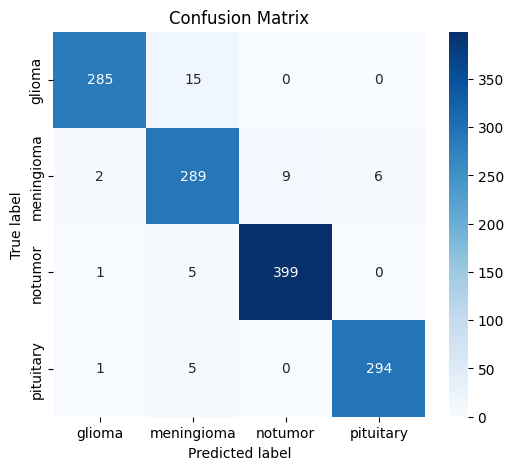

Accuracy: 0.9664


(0.9664378337147216,
 array([[285,  15,   0,   0],
        [  2, 289,   9,   6],
        [  1,   5, 399,   0],
        [  1,   5,   0, 294]]))

In [12]:
evaluate_model(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    device=device
)


In [13]:
import timm
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = timm.create_model('convmixer_768_32.in1k', pretrained=True, num_classes=4)
model = model.to(device)

def accuracy(preds, labels):
    return (preds.argmax(axis=1) == labels).float().mean()

num_epochs = 10
adam = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam, T_max=num_epochs)
criterion = nn.functional.cross_entropy

hist = train(model, train_loader, valid_loader, adam, scheduler, criterion, accuracy, num_epochs, device)

result_convmixer = {
    "train_loss": hist.train_loss,
    "train_metric": hist.train_metric,
    "valid_loss": hist.valid_loss,
    "valid_metric": hist.valid_metric,
}

torch.save(hist.best_model, "brain-tumor-convmixer.pt")

model.safetensors:   0%|          | 0.00/84.9M [00:00<?, ?B/s]

Epoch 1/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10:


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Test acc (last) = 0.9870426829268293, Test acc (best) = 0.9870426829268293


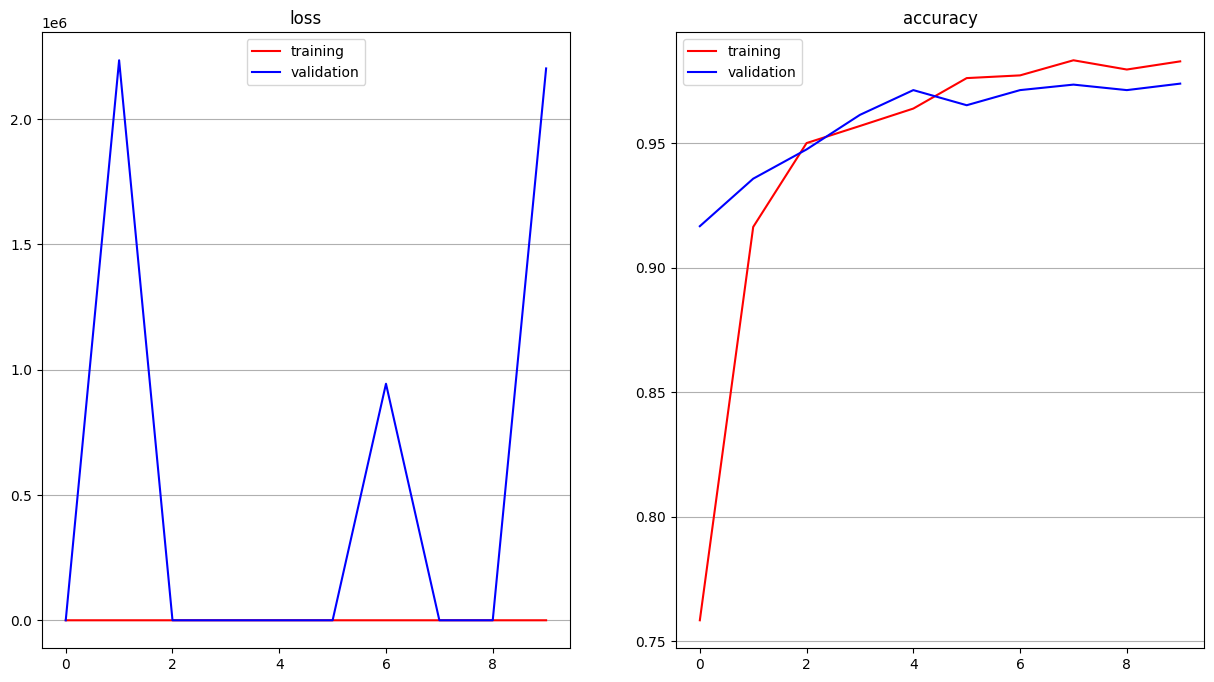

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(range(num_epochs), hist.train_loss, label='training', color='r')
ax[0].plot(range(num_epochs), hist.valid_loss, label='validation', color='b')
ax[0].set_title('loss')
ax[0].legend()
ax[0].grid(axis='y')

ax[1].plot(range(num_epochs), hist.train_metric, label='training', color='r')
ax[1].plot(range(num_epochs), hist.valid_metric, label='validation', color='b')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].grid(axis='y')

model.load_state_dict(hist.last_model)
_, last_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
model.load_state_dict(hist.best_model)
_, best_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
print(f"Test acc (last) = {last_acc}, Test acc (best) = {best_acc}")

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9931    0.9633    0.9780       300
  meningioma     0.9589    0.9902    0.9743       306
     notumor     0.9951    0.9951    0.9951       405
   pituitary     1.0000    0.9967    0.9983       300

    accuracy                         0.9870      1311
   macro avg     0.9868    0.9863    0.9864      1311
weighted avg     0.9873    0.9870    0.9871      1311



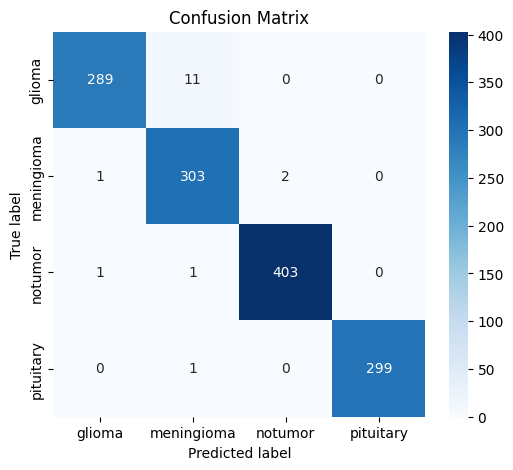

Accuracy: 0.9870


(0.9870327993897788,
 array([[289,  11,   0,   0],
        [  1, 303,   2,   0],
        [  1,   1, 403,   0],
        [  0,   1,   0, 299]]))

In [15]:
evaluate_model(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    device=device
)


In [16]:
import json

with open("result.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "result_resnet": result_resnet,
            "result_convmixer": result_convmixer,
        },
        f,
        indent=4
    )


In [17]:
# import json

# json.dump({
#     "result_resnet": result_resnet,
#     "result_convmixer": result_convmixer,
# }, "result.json")